In [1]:
#!/usr/bin/env python3
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pyhf

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass

### Get B2TF effs

In [2]:
b2tf_effs = np.genfromtxt('./B2TF-Trigger/JZ_numerics/b2tf_effs.csv',delimiter=',',names=True)
b2tf_data_df = pd.DataFrame(b2tf_effs,columns=b2tf_effs.dtype.names)
b2tf_data_df['dm'] = b2tf_data_df['m1']-b2tf_data_df['m0']

### Get ATLAS-EXOT-2019-23 effs

In [3]:
atlas_effs = np.genfromtxt('./ATLAS-EXOT-2019-23/atlas_exot_2019_23_effs.csv',delimiter=',',names=True)
atlas_data_df = pd.DataFrame(atlas_effs,columns=atlas_effs.dtype.names)
atlas_data_df['dm'] = atlas_data_df['m1']-atlas_data_df['m0']

### Add Cross-Sections

In [4]:
xsecsNLO = np.genfromtxt('./B2TF-Trigger/JZ_numerics/xsecsN3LO.csv',names=True,delimiter=',')
xsecList =  np.interp(b2tf_effs['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
b2tf_data_df['xsecfb'] = xsecList*1000
xsecList =  np.interp(atlas_effs['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
atlas_data_df['xsecfb'] = xsecList*1000

### Add number of signal, background and observed events

In [5]:
for df in [b2tf_data_df,atlas_data_df]:
    df['nb'] = 10.0 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nbError'] = 6.0 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nobs'] = 10.0  # Assume nobs = nb (expected)
    lumi = 139.0
    df['ns'] = df['eff']*df['xsecfb']*lumi

### Compute significance

In [6]:
b2tf_data_df['Z0'] = b2tf_data_df['ns']/np.sqrt(b2tf_data_df['nb']+b2tf_data_df['nbError']**2)
atlas_data_df['Z0'] = atlas_data_df['ns']/np.sqrt(atlas_data_df['nb']+atlas_data_df['nbError']**2)

### Compute Upper Limit

In [7]:
ns = 10.0 # dummy value to compute muUL
nb = b2tf_data_df['nb'].unique()[0]
nobs = b2tf_data_df['nobs'].unique()[0]
nbError = b2tf_data_df['nbError'].unique()[0]

model = pyhf.simplemodels.uncorrelated_background(
    signal=[ns], bkg=[nb], bkg_uncertainty=[nbError]
)
observations = [nobs]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)
scan = None
muUL_obs, _ = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, scan, return_results=False
)
ns95 = muUL_obs*ns


def getUL(dataDict):

    muUL = ns95/dataDict['ns']
    return muUL

In [8]:
b2tf_data_df['muUL'] =  b2tf_data_df[['ns','nb','nbError','nobs']].apply(getUL, axis=1,raw=False)
atlas_data_df['muUL'] =  atlas_data_df[['ns','nb','nbError','nobs']].apply(getUL, axis=1,raw=False)

### Plot Results: mS = 500 GeV

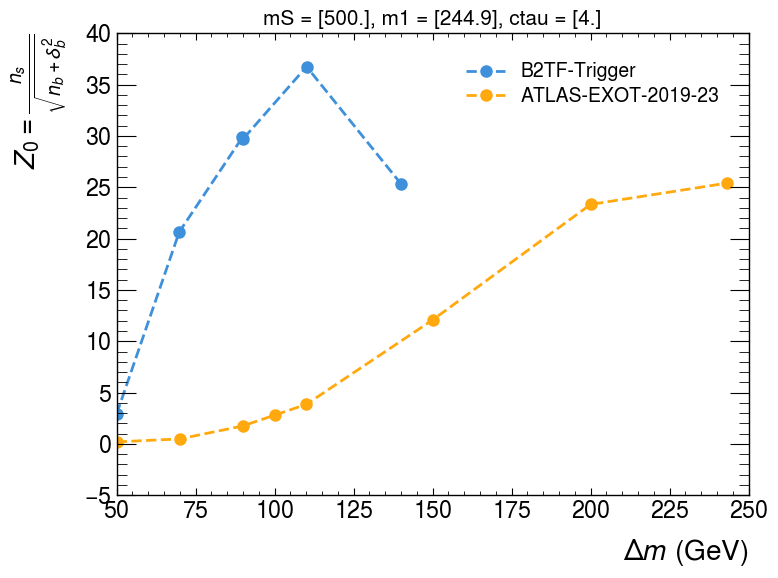

In [9]:
ms = 500.0
ctau = 4.0
# Filter data
b2tf_data_df_filter = b2tf_data_df[(b2tf_data_df['ms'] == ms) & (b2tf_data_df['ctau'] == ctau)]
b2tf_data_df_filter = b2tf_data_df_filter.sort_values('dm')

atlas_data_df_filter = atlas_data_df[(atlas_data_df['ms'] == ms) & (np.abs(atlas_data_df['ctau']-ctau) < 0.1)]
atlas_data_df_filter = atlas_data_df_filter.sort_values('dm')


plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['Z0'],'o--',label='B2TF-Trigger')
plt.plot(atlas_data_df_filter['dm'],atlas_data_df_filter['Z0'],'o--',label='ATLAS-EXOT-2019-23')
plt.xlabel(r'$\Delta m$ (GeV)')
plt.ylabel(r'$Z_0 = \frac{n_s}{\sqrt{n_b + \delta_b^2}}$')
plt.title(f'mS = {b2tf_data_df_filter['ms'].unique()}, m1 = {b2tf_data_df_filter['m1'].unique()}, ctau = {b2tf_data_df_filter['ctau'].unique()}',fontsize=15)
plt.legend()
plt.show()

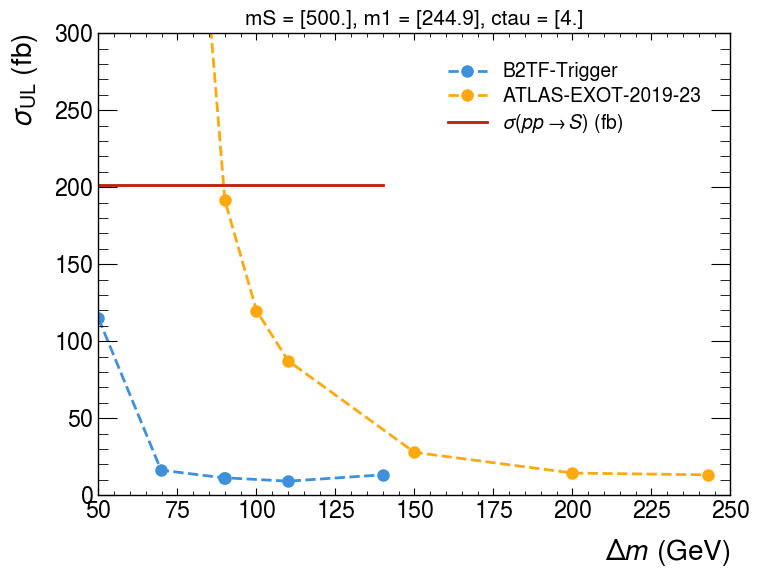

In [10]:

plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['muUL']*b2tf_data_df_filter['xsecfb'],
         'o--',label='B2TF-Trigger')
plt.plot(atlas_data_df_filter['dm'],atlas_data_df_filter['muUL']*atlas_data_df_filter['xsecfb'],
         'o--',label='ATLAS-EXOT-2019-23')
plt.xlabel(r'$\Delta m$ (GeV)')
plt.ylabel(r'$\sigma_{\rm UL}$ (fb)')
plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['xsecfb'],
         label=r'$\sigma(p p \rightarrow S)$ (fb)')
plt.title(f'mS = {b2tf_data_df_filter['ms'].unique()}, m1 = {b2tf_data_df_filter['m1'].unique()}, ctau = {b2tf_data_df_filter['ctau'].unique()}',fontsize=15)
# plt.yscale('log')
plt.ylim(0,300.0)
plt.legend()
plt.show()

### Plot Results: mS = 2000 GeV

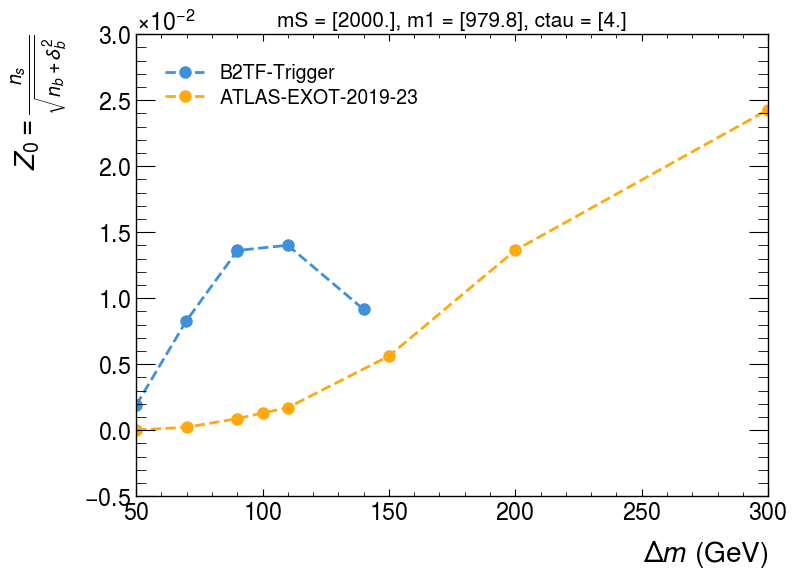

In [11]:
ms = 2000.0
ctau = 4.0
# Filter data
b2tf_data_df_filter = b2tf_data_df[(b2tf_data_df['ms'] == ms) & (b2tf_data_df['ctau'] == ctau)]
b2tf_data_df_filter = b2tf_data_df_filter.sort_values('dm')

atlas_data_df_filter = atlas_data_df[(atlas_data_df['ms'] == ms) & (np.abs(atlas_data_df['ctau']-ctau) < 0.1)]
atlas_data_df_filter = atlas_data_df_filter.sort_values('dm')


plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['Z0'],'o--',label='B2TF-Trigger')
plt.plot(atlas_data_df_filter['dm'],atlas_data_df_filter['Z0'],'o--',label='ATLAS-EXOT-2019-23')
plt.xlabel(r'$\Delta m$ (GeV)')
plt.ylabel(r'$Z_0 = \frac{n_s}{\sqrt{n_b + \delta_b^2}}$')
plt.title(f'mS = {b2tf_data_df_filter['ms'].unique()}, m1 = {b2tf_data_df_filter['m1'].unique()}, ctau = {b2tf_data_df_filter['ctau'].unique()}',fontsize=15)
plt.legend()
plt.show()

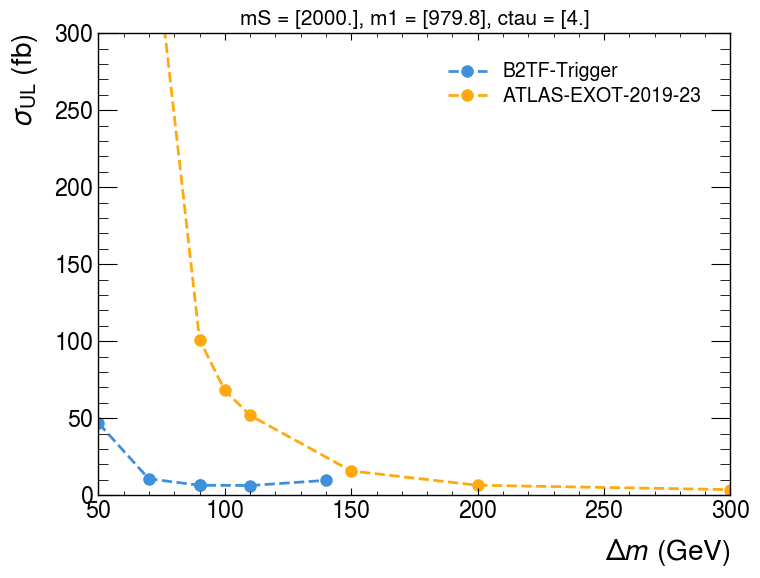

In [13]:

plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['muUL']*b2tf_data_df_filter['xsecfb'],
         'o--',label='B2TF-Trigger')
plt.plot(atlas_data_df_filter['dm'],atlas_data_df_filter['muUL']*atlas_data_df_filter['xsecfb'],
         'o--',label='ATLAS-EXOT-2019-23')
plt.xlabel(r'$\Delta m$ (GeV)')
plt.ylabel(r'$\sigma_{\rm UL}$ (fb)')
plt.ylim(0,300.0)

# plt.plot(b2tf_data_df_filter['dm'],b2tf_data_df_filter['xsecfb'],
        #  label=r'$\sigma(p p \rightarrow S)$ (fb)')
plt.title(f'mS = {b2tf_data_df_filter['ms'].unique()}, m1 = {b2tf_data_df_filter['m1'].unique()}, ctau = {b2tf_data_df_filter['ctau'].unique()}',fontsize=15)
plt.legend()
plt.show()